In [1]:
import matplotlib.pyplot as plt

from projectq import MainEngine
from projectq.meta import Compute, Control, Uncompute
from projectq.ops import All, CNOT, H, Measure, X, Z
from projectq.types import Qureg, Qubit

In [2]:
def xor(q1: Qubit, q2: Qubit, output: Qubit):
    CNOT | (q1, output)
    CNOT | (q2, output)

In [3]:
def sudoku_oracle(e: MainEngine, inputs: Qureg[Qubit], tmp: Qureg[Qubit], output: Qubit):
    with Compute(e):
        xor(inputs[0], inputs[1], tmp[0])
        xor(inputs[1], inputs[3], tmp[1])
        xor(inputs[0], inputs[2], tmp[2])
        xor(inputs[2], inputs[3], tmp[3])
    with Control(e, tmp):
        X | output
    Uncompute(e)

In [4]:
def reflect_zero(e: MainEngine, inputs: Qureg[Qubit]):
    with Compute(e):
        All(X) | inputs
    with Control(e, inputs[:len(inputs) - 1]):
        Z | inputs[-1]
    Uncompute(e)

In [5]:
def grover_circuit():
    eng = MainEngine()

    inputs = eng.allocate_qureg(4)
    tmp = eng.allocate_qureg(4)
    pkb = eng.allocate_qubit()

    All(H) | inputs

    X | pkb
    H | pkb

    for _ in range(2):
        sudoku_oracle(eng, inputs, tmp, pkb)

        with Compute(eng):
            All(H) | inputs

        reflect_zero(eng, inputs)
        Uncompute(eng)

    All(Measure) | inputs
    # garbage
    All(Measure) | tmp
    Measure | pkb

    eng.flush()

    return map(lambda x: int(x), inputs)

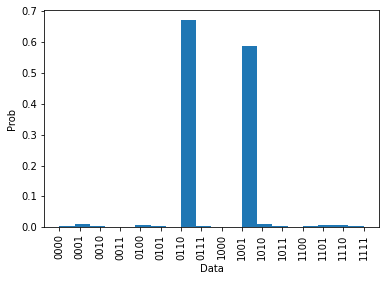

In [8]:
data = [''.join(map(lambda x: str(x), grover_circuit())) for _ in range(1000)]
plt.hist(sorted(data), density=True, bins=20)
plt.ylabel('Prob')
plt.xlabel('Data')
plt.xticks(rotation='vertical')
plt.show()